# Pretraining a Customer Support Model on X (former Twitter) Data
copyright 2023-2024, Denis Rothman

This is an educational notebook to show how to implement a Hugging Face RoRobertaForCausalLM model on messages on X(former Twitter). The goal is only to show the method(see limitations below).

**Pretraining a Generative AI model from scratch**

**Dataset:** Tweets from 20 Top Brands by Volume  
**Model:**  RobertaForCausalLM

In **October 2024**, wandb.ai training metrics were added while training. You can now view your model's metrics on Hugging Face.  

**July 21,2024 Training parameter tweaking that reduces training time** such as the use of mixed precision. For more see the explanations in *Step7: Initializing the trainer.*

**April 29, 2024 update for conflict resolution of** *Step 2 Installing Hugging Face transformer and datasets*  **between the most recent accelerate, Transformers, and datasets packages. It was necessary to freeze the versions pending unification of the most recent versions of Hugging Face installation packages**


![](https://i.imgur.com/nTv3Iuu.png)




The goal of the notebook is to train a Hugging Face RobertaForCausalLM model to simulate a customer support chat agent for X (former Twitter)

This notebook requires a GPU.

**Customer Support on Twitter**
Over 2 million tweets and replies from the biggest brands on Twitter

https://www.kaggle.com/datasets/thoughtvector/customer-support-on-twitter

**Limitations**:

The scope of pretraining was limited to a subset of the dataset for time constraints. You can train the full dataset on Google Colab or another platform. You can also select another model if you find the generalized reponses insufficient.The reponses are only there to show how the system workds.

RoBERTa is not a standard generative AI model such as GPT models as in the Chapter07 directory. However, it can be implemented as a reasonably interesting autoregressive(token by token loop) model that illustrates how to begin to explore how generative AI works.

In the following chapters we will be using **GPT-4** and other **LLM** models. *However, exploring smaller open source models for a specific domain can sometimes provide everything we need for our project.*


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Kaggle credentials for authentification

In [2]:
import os
import json
with open(os.path.expanduser("drive/MyDrive/files/kaggle.json"), "r") as f:
    kaggle_credentials = json.load(f)

kaggle_username = kaggle_credentials["username"]
kaggle_key = kaggle_credentials["key"]

os.environ["KAGGLE_USERNAME"] = kaggle_username
os.environ["KAGGLE_KEY"] = kaggle_key

In [3]:
try:
  import kaggle
except:
  !pip install kaggle
  import kaggle

In [4]:
kaggle.api.authenticate()

#Step 1: Downloading the dataset

https://www.kaggle.com/datasets/thoughtvector/customer-support-on-twitter

In [5]:
!kaggle datasets download -d thoughtvector/customer-support-on-twitter

Dataset URL: https://www.kaggle.com/datasets/thoughtvector/customer-support-on-twitter
License(s): CC-BY-NC-SA-4.0
100% 169M/169M [00:12<00:00, 19.1MB/s]
100% 169M/169M [00:12<00:00, 14.3MB/s]


In [6]:
import zipfile

with zipfile.ZipFile('/content/customer-support-on-twitter.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

print("File Unzipped!")

File Unzipped!


#Step 2: Installing Hugging Face transformers and datasets

**April 2023 update From Hugging Face Issue 22816**

https://github.com/huggingface/transformers/issues/22816

"The PartialState import was added as a dependency on the transformers development branch yesterday. PartialState was added in the 0.17.0 release in accelerate, and so for the development branch of transformers, accelerate >= 0.17.0 is required.

Downgrading the transformers version removes the code which is importing PartialState."

Denis Rothman: The following cell imports the latest version of Hugging Face transformers but without downgrading it.

To adapt to the Hugging Face upgrade, A GPU accelerator was activated using the Google Colab Pro with the following NVIDIA GPU:
GPU Name: NVIDIA A100-SXM4-40GB

**April 29, 2024 update for conflict resolution of** *Step 2 Installing Hugging Face transformer and datasets*  **between the most recent accelerate, Transformers, and datasets packages. It was necessary to freeze the versions pending unification of the most recent versions of Hugging Face installation packages**

The conflict between the versions of the `hugging face-hub` in the `transformers` and `datasets` installations arises from the specific version requirements of these libraries and their dependencies on `huggingface-hub`. Here's a detailed explanation of the situation:

### Initial Setup and Conflict

1. **Transformers and Accelerate Installation**:
   - When the program initially installed `transformers` and `accelerate`, the `huggingface-hub` version 0.20.3 was installed as a dependency. This version was compatible with the requirements of both `transformers` and `accelerate` at that time.
   - Message: `Requirement already satisfied: huggingface-hub in /usr/local/lib/python3.10/dist-packages (from accelerate) (0.20.3)`

2. **Datasets Installation**:
   - Subsequently, when the `datasets` library was installed, it required a newer version of `huggingface-hub` (version 0.22.2). This was because `datasets` had been updated to depend on newer features or fixes introduced in `huggingface-hub` after version 0.20.3.
   - Message: `Successfully installed datasets-2.19.0 dill-0.3.8 huggingface-hub-0.22.2 multiprocess-0.70.16 xxhash-3.4.1`

3. **Version Conflict**:
   - The installation of `datasets` led to an upgrade of `huggingface-hub` from 0.20.3 to 0.22.2. This upgrade caused a conflict because `huggingface-hub` was already loaded into memory (imported) at the older version (0.20.3) as part of the Python runtime environment when `accelerate` and `transformers` were installed.
   - Warning Message: `WARNING: The following packages were previously imported in this runtime: [huggingface_hub] You must restart the runtime in order to use newly installed versions.`


### Resolution Strategy

To resolve this version conflict without requiring frequent restarts of the runtime, especially in environments like Jupyter notebooks or online IDEs, the program adjusted the library versions as follows:

- **Unified Library Version Installation**:
  - The program chose to install specific versions of `accelerate`, `transformers`, and `datasets` that are compatible with the same version of `huggingface-hub`. By pinning these libraries to versions that all require the same `huggingface-hub` version, it avoided the need for mid-session upgrades that necessitate a runtime restart.
  - Commands:
    ```bash
    !pip install accelerate==0.29.3
    !pip install Transformers==4.40.1
    !pip install datasets==2.16.0
    ```

By aligning the versions of `accelerate`, `transformers`, and `datasets` to those that share a common dependency version of `huggingface-hub`, the program ensures that all libraries are compatible without causing interruptions due to dependency conflicts.



In [7]:
!pip install accelerate==0.29.3
!pip install Transformers==4.40.1
!pip install datasets==2.16.0 #installing Hugging Face datasets for data loading and preprocessing

from accelerate import Accelerator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 7.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

creating subdirectories to store the datasets, the logs and the trained model

In [8]:
!mkdir -p /content/model/dataset/
!mkdir -p /content/model/model/
!mkdir -p /content/model/logs/

# Step 3:  Loading and filtering the data

We will use a subset of the dataset to train the model.

In [9]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/twcs/twcs.csv')

# Check the first few rows to understand the data
print(df.head())

   tweet_id   author_id  inbound                      created_at  \
0         1  sprintcare    False  Tue Oct 31 22:10:47 +0000 2017   
1         2      115712     True  Tue Oct 31 22:11:45 +0000 2017   
2         3      115712     True  Tue Oct 31 22:08:27 +0000 2017   
3         4  sprintcare    False  Tue Oct 31 21:54:49 +0000 2017   
4         5      115712     True  Tue Oct 31 21:49:35 +0000 2017   

                                                text response_tweet_id  \
0  @115712 I understand. I would like to assist y...                 2   
1      @sprintcare and how do you propose we do that               NaN   
2  @sprintcare I have sent several private messag...                 1   
3  @115712 Please send us a Private Message so th...                 3   
4                                 @sprintcare I did.                 4   

   in_response_to_tweet_id  
0                      3.0  
1                      1.0  
2                      4.0  
3                      5.0  
4

Extracting relevant data

In this case, we are extracting the text

In [10]:
# Extract tweets from the 'text' column or any other relevant column
tweets = df['text'].dropna().tolist()  # This assumes the column with tweets is named 'text'

In [11]:
# Convert the list of tweets to a DataFrame
df_tweets = pd.DataFrame(tweets, columns=['text'])

# Save the DataFrame to a CSV file
df_tweets.to_csv('tweets.csv', index=False, encoding='utf-8')

In [12]:
# Checking the length of df
formatted_length = "{:,}".format(len(df_tweets))
print(formatted_length)

2,811,774


Checking the extraction

In [13]:
for tweet in tweets[:10]:  # This will display the first 5 tweets
    print(tweet)

@115712 I understand. I would like to assist you. We would need to get you into a private secured link to further assist.
@sprintcare and how do you propose we do that
@sprintcare I have sent several private messages and no one is responding as usual
@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’ at the top of your profile.
@sprintcare I did.
@115712 Can you please send us a private message, so that I can gain further details about your account?
@sprintcare is the worst customer service
@115713 This is saddening to hear. Please shoot us a DM, so that we can look into this for you. -KC
@sprintcare You gonna magically change your connectivity for me and my whole family ? 🤥 💯
@115713 We understand your concerns and we'd like for you to please send us a Direct Message, so that we can further assist you. -AA


filtering the extraction to clean it and apply lowercase conversion

In [14]:
import re

def filter_tweet(tweet):
    # Keep only characters a to z, spaces, and apostrophes, then convert to lowercase
    return re.sub(r'[^a-z\s\']', '', tweet.lower())

filtered_tweets = [filter_tweet(tweet) for tweet in tweets]

In [15]:
f=30
filtered_tweets = [tweet for tweet in filtered_tweets if len(tweet.split()) > f]  # Only keep tweets with more than f words

In [16]:
for filtered_tweet in filtered_tweets[:10]:  # This will display the first 5 tweets
    print(filtered_tweet)

marksandspencer i check with the gov office and legal they stated you are not right but its funny how the other stores dont but you do no wonder lidl and the rest are beating you
marksandspencer ou must charge at least p a bag including vat for carrier bags that are all of the following

unused  its new and hasnt already been used for sold goods to be taken away or delivered
plastic and  microns thick or less
it has handles an opening and isnt sealed
marksandspencer arent require charge  a bag
paper bags
shops in airports or on board trains aeroplanes or ships
bags which only contain certain items such as unwrapped food raw meat and fish where there is a food safety risk prescription medicines uncovered blades seeds bulbs amp s
 hi you can change your microsoft account email through the steps here httpstcodkehohboyy  if the email your son wants to change to is already associated with a microsoft account you'll need to follow those steps to switch the email address on that account too z

In [17]:
# Checking the length of dataset
formatted_length = "{:,}".format(len(filtered_tweets))
print(formatted_length)

228,637


save the dataset

In [18]:
import csv
# Save to CSV
with open('/content/model/dataset/processed_tweets.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for tweet in filtered_tweets:
        writer.writerow([tweet])

check the file

In [19]:
import csv

# Read from CSV
with open('/content/model/dataset/processed_tweets.csv', 'r') as file:
    reader = csv.reader(file)

    # Use islice from itertools to only get the first 5 lines
    from itertools import islice
    for row in islice(reader, 5):
        print(row[0])

marksandspencer i check with the gov office and legal they stated you are not right but its funny how the other stores dont but you do no wonder lidl and the rest are beating you
marksandspencer ou must charge at least p a bag including vat for carrier bags that are all of the following

unused  its new and hasnt already been used for sold goods to be taken away or delivered
plastic and  microns thick or less
it has handles an opening and isnt sealed
marksandspencer arent require charge  a bag
paper bags
shops in airports or on board trains aeroplanes or ships
bags which only contain certain items such as unwrapped food raw meat and fish where there is a food safety risk prescription medicines uncovered blades seeds bulbs amp s
 hi you can change your microsoft account email through the steps here httpstcodkehohboyy  if the email your son wants to change to is already associated with a microsoft account you'll need to follow those steps to switch the email address on that account too z

#Step 4: Checking Resource Constraints: GPU and CUDA

In [20]:
!nvidia-smi

Sun Jul 21 16:38:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [21]:
#@title Checking that PyTorch Sees CUDA
import torch
torch.cuda.is_available()

True

#Step 5: Defining the configuration of the model

In [22]:
from transformers import RobertaConfig, RobertaForCausalLM

config = RobertaConfig(
    vocab_size=52_000,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
    is_decoder=True,  # Set up the model for potential seq2seq use, allowing for autoregressive outputs
)

In [23]:
print(config)

RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}



define and print model

In [24]:
# Create the RobertaForCausalLM model with the specified config
model = RobertaForCausalLM(config=config)
print(model)

RobertaForCausalLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

##  defining the tokenizer

In [25]:
from transformers import RobertaTokenizer

# Initialize the tokenizer using the 'roberta-base' pre-trained model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:99: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [26]:
# Display special tokens
print("Special tokens:", tokenizer.special_tokens_map)

Special tokens: {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}


## Exploring the parameters

In [27]:
print(model.num_parameters())

83504416


In [28]:
LP=list(model.parameters())
lp=len(LP)
print(lp)
for p in range(0,lp):
  print(LP[p])

106
Parameter containing:
tensor([[ 0.0037,  0.0099, -0.0023,  ...,  0.0056, -0.0140,  0.0025],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0157, -0.0244, -0.0113,  ...,  0.0148,  0.0046, -0.0286],
        ...,
        [-0.0065, -0.0196, -0.0043,  ...,  0.0219,  0.0238,  0.0077],
        [ 0.0026,  0.0397, -0.0023,  ...,  0.0046,  0.0181,  0.0015],
        [ 0.0222,  0.0009, -0.0075,  ..., -0.0003, -0.0159,  0.0146]],
       requires_grad=True)
Parameter containing:
tensor([[ 0.0144, -0.0011, -0.0408,  ...,  0.0103,  0.0240, -0.0271],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0005,  0.0118,  0.0155,  ..., -0.0265,  0.0229, -0.0065],
        ...,
        [-0.0066,  0.0102,  0.0013,  ..., -0.0170, -0.0294, -0.0147],
        [ 0.0247, -0.0207,  0.0181,  ..., -0.0243,  0.0013, -0.0024],
        [-0.0182, -0.0276,  0.0138,  ..., -0.0134,  0.0296, -0.0029]],
       requires_grad=True)
Parameter containing:
tensor([

In [29]:
#Shape of each tensor in the model
LP = list(model.parameters())
for i, tensor in enumerate(LP):
    print(f"Shape of tensor {i}: {tensor.shape}")

Shape of tensor 0: torch.Size([52000, 768])
Shape of tensor 1: torch.Size([514, 768])
Shape of tensor 2: torch.Size([1, 768])
Shape of tensor 3: torch.Size([768])
Shape of tensor 4: torch.Size([768])
Shape of tensor 5: torch.Size([768, 768])
Shape of tensor 6: torch.Size([768])
Shape of tensor 7: torch.Size([768, 768])
Shape of tensor 8: torch.Size([768])
Shape of tensor 9: torch.Size([768, 768])
Shape of tensor 10: torch.Size([768])
Shape of tensor 11: torch.Size([768, 768])
Shape of tensor 12: torch.Size([768])
Shape of tensor 13: torch.Size([768])
Shape of tensor 14: torch.Size([768])
Shape of tensor 15: torch.Size([3072, 768])
Shape of tensor 16: torch.Size([3072])
Shape of tensor 17: torch.Size([768, 3072])
Shape of tensor 18: torch.Size([768])
Shape of tensor 19: torch.Size([768])
Shape of tensor 20: torch.Size([768])
Shape of tensor 21: torch.Size([768, 768])
Shape of tensor 22: torch.Size([768])
Shape of tensor 23: torch.Size([768, 768])
Shape of tensor 24: torch.Size([768])
Sh

In [30]:
#counting the parameters
np=0
for p in range(0,lp):#number of tensors
  PL2=True
  try:
    L2=len(LP[p][0]) #check if 2D
  except:
    L2=1             #not 2D but 1D
    PL2=False
  L1=len(LP[p])
  L3=L1*L2
  np+=L3             # number of parameters per tensor
  if PL2==True:
    print(p,L1,L2,L3)  # displaying the sizes of the parameters
  if PL2==False:
    print(p,L1,L3)  # displaying the sizes of the parameters

print(np)              # total number of parameters

0 52000 768 39936000
1 514 768 394752
2 1 768 768
3 768 768
4 768 768
5 768 768 589824
6 768 768
7 768 768 589824
8 768 768
9 768 768 589824
10 768 768
11 768 768 589824
12 768 768
13 768 768
14 768 768
15 3072 768 2359296
16 3072 3072
17 768 3072 2359296
18 768 768
19 768 768
20 768 768
21 768 768 589824
22 768 768
23 768 768 589824
24 768 768
25 768 768 589824
26 768 768
27 768 768 589824
28 768 768
29 768 768
30 768 768
31 3072 768 2359296
32 3072 3072
33 768 3072 2359296
34 768 768
35 768 768
36 768 768
37 768 768 589824
38 768 768
39 768 768 589824
40 768 768
41 768 768 589824
42 768 768
43 768 768 589824
44 768 768
45 768 768
46 768 768
47 3072 768 2359296
48 3072 3072
49 768 3072 2359296
50 768 768
51 768 768
52 768 768
53 768 768 589824
54 768 768
55 768 768 589824
56 768 768
57 768 768 589824
58 768 768
59 768 768 589824
60 768 768
61 768 768
62 768 768
63 3072 768 2359296
64 3072 3072
65 768 3072 2359296
66 768 768
67 768 768
68 768 768
69 768 768 589824
70 768 768
71 768 768

# Step 6: Creating and processing the dataset

In [31]:
#load dataset
from datasets import load_dataset
dataset = load_dataset('csv', data_files='/content/model/dataset/processed_tweets.csv', column_names=["text"])

Generating train split: 0 examples [00:00, ? examples/s]

In [32]:
# split datasets into train and eval
from datasets import DatasetDict

dataset = dataset['train'].train_test_split(test_size=0.1)  # 10% for evaluation
dataset = DatasetDict(dataset)

In [33]:
# Tokenize datasets:
# - If a record's length is less than `max_length`, it's padded to ensure all records have the same length.
# - If a record's length exceeds `max_length`, it's truncated to the specified max length.

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/205773 [00:00<?, ? examples/s]

Map:   0%|          | 0/22864 [00:00<?, ? examples/s]

In [34]:
# datacollator to batch items together for training and evaluation
from transformers import DataCollatorForLanguageModeling

# Define the data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # For causal (autoregressive) language modeling
)

# Step 7: Initializing the trainer

The number of epochs can be empirically increased until the
accuracy versus training time reaches a limit.

## July 21, 2024 Parameter tweaking
(you can try other scenarios!)

Here’s a brief explanation of each parameter in the `TrainingArguments`:

1. **`output_dir`**: Specifies the directory where the model, configuration, and tokenizer will be saved.

2. **`overwrite_output_dir`**: If set to `True`, the output directory will be overwritten if it already exists, ensuring that the training starts with a clean state.

3. **`num_train_epochs`**: Determines the number of times to iterate over the entire training dataset. More epochs can lead to higher accuracy but increase training time.

4. **`per_device_train_batch_size`**: The number of examples processed on each device (e.g., GPU) per training step. Larger batch sizes can speed up training but may require more memory.

*Note: The batch size was increased to which consumes GPU RAM. Reduce this size if necessary depending on the machine you are running the model on.*

5. **`per_device_eval_batch_size`**: The number of examples processed on each device per evaluation step. This does not need to be as large as the training batch size.

6. **`warmup_steps`**: The number of steps to perform learning rate warming up. This can help stabilize the model’s training early in the process by gradually increasing the learning rate from zero.

7. **`weight_decay`**: A regularization technique that involves adding a small penalty for larger weights to the loss to prevent overfitting.

8. **`save_steps`**: The model is saved after every specified number of steps, useful for not losing training progress and for analyzing the model at different stages.

9. **`save_total_limit`**: The maximum number of model checkpoints to keep. Older files are deleted as new ones are saved, managing disk usage effectively.

10. **`logging_dir`**: Directory where logs will be written, useful for monitoring training progress through TensorBoard or other visualization tools.

11. **`logging_steps`**: Determines how often to log training information. Frequent logging provides detailed training progress.

12. **`logging_first_step`**: Ensures that logging occurs at the first training step, which can be helpful for ensuring that the logging setup is correct.

13. **`evaluation_strategy`**: Defines the strategy to use for evaluating the model. Setting it to `"steps"` means the model will be evaluated at regular step intervals.

14. **`eval_steps`**: Specifies how often to evaluate the model. This sets the frequency of evaluation within the training loop, ensuring regular feedback on the model’s performance.

15.**fp16=True** Using mixed-precision training can provide a substantial speed boost. This utilizes float16 computations which are faster and require less memory.

**Why it is not necessary to add additional evaluation code after training:**

Given the configuration, the model is evaluated every 500 steps during training due to the `evaluation_strategy` and `eval_steps` parameters. This setup provides a continuous insight into the model's performance and adjusts as needed without manually invoking evaluations. Since evaluations are automatically handled at regular intervals, adding a separate evaluation block after training might be redundant unless there is a specific need, such as a final evaluation with different parameters or on a different dataset. The current setup ensures that the model's final state at the end of training is already evaluated if the total number of training steps aligns with the evaluation interval.

As such the subsequent cells are commented.

In [35]:
# to display the time every x steps suring training
from transformers import Trainer
from datetime import datetime
from typing import Dict, Any

class CustomTrainer(Trainer):
    def log(self, logs: Dict[str, Any]) -> None:
        super().log(logs)
        if "step" in logs:  # Check if "step" key is in the logs dictionary
            step = int(logs["step"])
            if step % self.args.eval_steps == 0:
                print(f"Current time at step {step}: {datetime.now()}")

In [46]:
import logging
from transformers import Trainer, TrainingArguments

# Set up Python logging
logging.basicConfig(level=logging.INFO)

training_args = TrainingArguments(
    output_dir="/content/model/model/",
    overwrite_output_dir=True,
    num_train_epochs=2,                  # can be increased to increase accuracy if productive
    per_device_train_batch_size=128,     # batch size per device
    per_device_eval_batch_size=128,      # batch size for evaluation
    warmup_steps=500,                    # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                   # strength of weight decay
    save_steps=10_000,                   # save a checkpoint every save_steps=10000
    save_total_limit=2,                  # the maximum number of checkpoint model files to keep
    logging_dir='/content/model/logs/',  # directory for storing logs
    logging_steps=10,                   # Log every 100 steps
    logging_first_step=True,             # Log the first step
    evaluation_strategy="steps",         # Evaluate every "eval_steps"
    eval_steps=500,                      # Evaluate every 500 steps
    fp16=True
)

In [47]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["test"]
)

# Step 8: Pretraining the model


In [48]:
%%time
trainer.train()

Step,Training Loss,Validation Loss
500,5.186500,5.171569
1000,4.786700,4.761583
1500,4.606200,4.560755
2000,4.514200,4.444450
2500,4.475400,4.376606
3000,4.376700,4.343147


CPU times: user 9min 19s, sys: 1.56 s, total: 9min 21s
Wall time: 9min 18s


TrainOutput(global_step=3216, training_loss=4.732618845517362, metrics={'train_runtime': 557.9352, 'train_samples_per_second': 737.623, 'train_steps_per_second': 5.764, 'total_flos': 1.3645541880741888e+16, 'train_loss': 4.732618845517362, 'epoch': 2.0})

**July 21, 2024, Sample run information:**

Mixed precision and high batch sizes significantly reduced training times.

*Display results*

**July 21,2024:** Not necessary since evaluation information is displayed during training reducing the running time of this notebook.

In [ ]:
#results = trainer.evaluate()
#print(results)

Evaluate the trainer

**July 21,2024:** Not necessary since evaluation information is displayed during training reducing the running time of this notebook.

In [ ]:
#trainer.evaluate()

#Step 9: Saving the trained model (+tokenizer + config) to disk

In [49]:
trainer.save_model("/content/model/model/")

In [ ]:
#Uncomment the following line to save the output for future use
#trainer.save_model("drive/MyDrive/files/model_C6/model/")

# Step 10: User Interface to Chat with the Generative AI Agent

In [ ]:
# For standalone run : transformer library
#!pip install Transformers

In [ ]:
#1.A.for standalone run : mount Google Drive and path to pretrained model
'''
from google.colab import drive
drive.mount('/content/drive')
model_path="drive/MyDrive/files/model_C6/model/"
'''

In [50]:
# 1.A For a run during the training session of this notebook,
# Load the trained model: model path
# local model path(comment for a standalone run):
model_path="/content/model/model/"

In [51]:
# 1.B Load the trained model and tokenizer : model and tokenizer
from transformers import RobertaConfig, RobertaForCausalLM
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForCausalLM.from_pretrained(model_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Running samples


In [52]:
# 2. Tokenize an input prompt
prompt = "I would like to know why they moved us"
inputs = tokenizer(prompt, return_tensors="pt", max_length=50, truncation=True)

# 3. Generate a response from the model
output = model.generate(**inputs, max_length=100, temperature=0.9, num_return_sequences=1)

# 4. Decode the generated output
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

print(generated_text)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


I would like to know why they moved us to the iphone x and they are not able to get a new iphone x and ios                                                                   


Example:    
Input   
I would like to assist       
output:   
I would like to assist you please give us your full name address and phone number so we can look into this for you

## Interface

In [53]:
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.8 MB/s eta 0:00:00


In [54]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from transformers import RobertaTokenizer, RobertaForCausalLM

# Define the function to generate response
def generate_response(prompt):
    inputs = tokenizer(prompt, return_tensors="pt", max_length=50, truncation=True)
    output = model.generate(**inputs, max_length=200, temperature=0.9, num_return_sequences=1)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

# Create widgets
text_input = widgets.Textarea(
    description='Prompt:',
    placeholder='Enter your prompt here...'
)

button = widgets.Button(
    description='Generate',
    button_style='success'
)

output_text = widgets.Output(layout={'border': '1px solid black', 'height': '100px'})

# Define button click event handler
def on_button_clicked(b):
    with output_text:
        clear_output()
        response = generate_response(text_input.value)
        print(response)

button.on_click(on_button_clicked)

# Display widgets
display(text_input, button, output_text)

Textarea(value='', description='Prompt:', placeholder='Enter your prompt here...')

Button(button_style='success', description='Generate', style=ButtonStyle())

Output(layout=Layout(border='1px solid black', height='100px'))

### Example

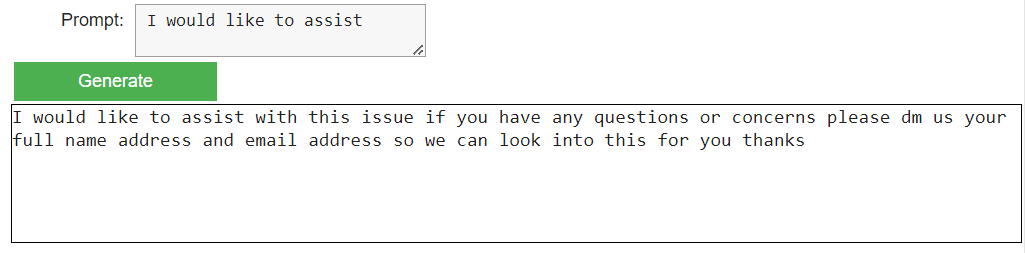